# Eigenvalue spectrum of covariance matrix

This notebook provides a brief interactive tutorial for initialization of SNNs in the fluctuation-driven regime.

In [1]:
# Imports
import sys

sys.path.append("../../stork")

import stork

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change default color cycler
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cm.batlow(np.linspace(0, 1, 10)))


import stork.utils
from utils.utils import *

from sklearn.decomposition import PCA

using spikeinit stork


In [2]:
# for reproducibility
np.random.seed(2025)

We first define some general simulation and plotting paramters

In [3]:
# Simulation parameters
dt = timestep = 1e-3  # timestep in s
duration = 2  # Duration in seconds
epsilon_calc_method = (
    "numerical"  # Choose between numerical or analytical way of computing epsilon
)

# Cosmetics and plotting
spike_amp = 2.0
plot_maxtime = 2.0  # seconds
plot_maxneurons = 100  # neurons

color_membrane = "#CCB380"
color_theta = "#454545"
line_colors = ["#969696", "#525252", "black"]

teal = "#009988"
orange = "#EE7733"

## Poisson distributed input spikes

As an example input, we generate homogenous Poisson spike trains and visualize them in a spike raster. We first set parameters of the input, i.e. the number of input neurons and their firing rate

In [4]:
# Input parameters

N = 2500  # Nb. presynaptic neurons
n_out = 2500  # nb. postsynapric neurons
nu = 3  # presynaptic firing rate

Finally, we generate example inputs and plot a spike raster

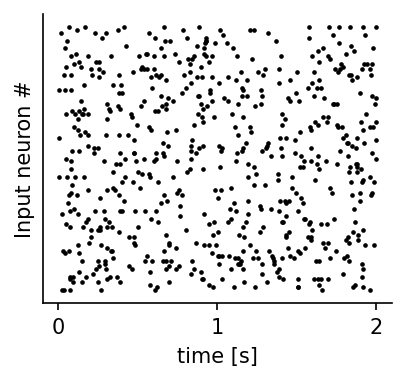

In [5]:
# generate Poisson Spike Trains
spikes = get_poisson_spikes(N, nu, duration, timestep)

# and plot them (at least the first 100 neurons and first 2 seconds)
plot_maxtime = 2.0  # seconds
plot_maxneurons = 100  # neurons

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_spikeraster(
    spikes, timestep, ax, max_time=plot_maxtime, max_neurons=plot_maxneurons
)
ax.set_xticks(np.arange(0, plot_maxtime + 1, 1))
ax.set_yticks([])
ax.set_ylabel("Input neuron #")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [6]:
# LIF parameters
tau_syn = 10e-3
tau_mem = 20e-3
theta = 1.0  # threshold
refractory_period = 2e-3  # refractory period in s

dcy_mem = float(np.exp(-timestep / tau_mem))
scl_mem = 1.0 - dcy_mem
dcy_syn = float(np.exp(-timestep / tau_syn))
scl_syn = 1.0 - dcy_syn

# Initialization target parameters
mu_U = 0.0  # Target mean of membrane potential distribution
xi = 2.0  # Target distance between membrane potential mean (mu_U) and firing threshold (1.0)
# in units of standard deviation
alpha = 0.9

mu_w, sigma_w = get_w_params(
    N=N,
    nu=nu,
    theta=theta,
    mu_U=mu_U,
    xi=xi,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    eps_calc_mode=epsilon_calc_method,
)
epsilon_bar, epsilon_hat = get_epsilon(
    calc_mode=epsilon_calc_method, tau_mem=tau_mem, tau_syn=tau_syn
)
mu_U = get_mu_U(N=N, nu=nu, epsilon_bar=epsilon_bar, mu_w=mu_w)
sigma_U = get_sigma_U(N=N, nu=nu, epsilon_hat=epsilon_hat, mu_w=mu_w, sigma_w=sigma_w)

Finally, we can sample the synaptic weights taking into account the input parameters and neuronal dynamics

In [7]:
# Get synaptic weights
mu_w, sigma_w = get_w_params(
    N=N,
    nu=nu,
    theta=theta,
    mu_U=mu_U,
    xi=xi,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    eps_calc_mode=epsilon_calc_method,
)
weights = np.stack([sample_normal(n_out, mu_w, sigma_w) for i in range(n_out)])
weights_ff = np.stack([sample_normal(N, mu_w, sigma_w) for i in range(n_out)])


# weights = np.random.normal(0, 1, (n_out, N))
# print(weights.shape)


## Analyse weight matrix

In [8]:
weights -= np.mean(weights)
print(np.mean(weights))

-1.0598455446597654e-18


In [9]:
# # Compute the current spectral radius
# current_spectral_radius = np.max(np.abs(np.linalg.eigvals(weights)))

# # Scale the weights
# desired_spectral_radius = 0.999
# scaling_factor = desired_spectral_radius / current_spectral_radius
# weights *= scaling_factor

# # Verify the new spectral radius
# new_spectral_radius = np.max(np.abs(np.linalg.eigvals(weights)))
# print(f"New spectral radius: {new_spectral_radius}")

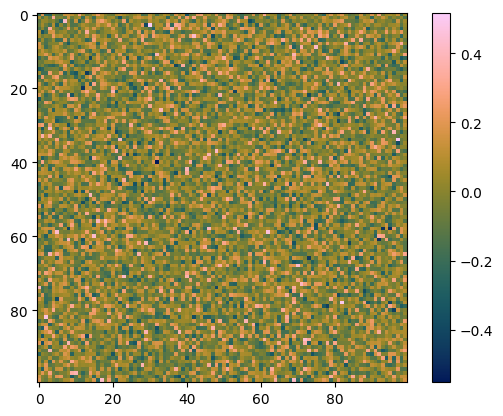

In [10]:
im = plt.imshow(weights[:100, :100], cmap=cm.batlow)
plt.colorbar(im)

In [11]:
eig_w = np.linalg.eigvals(weights)

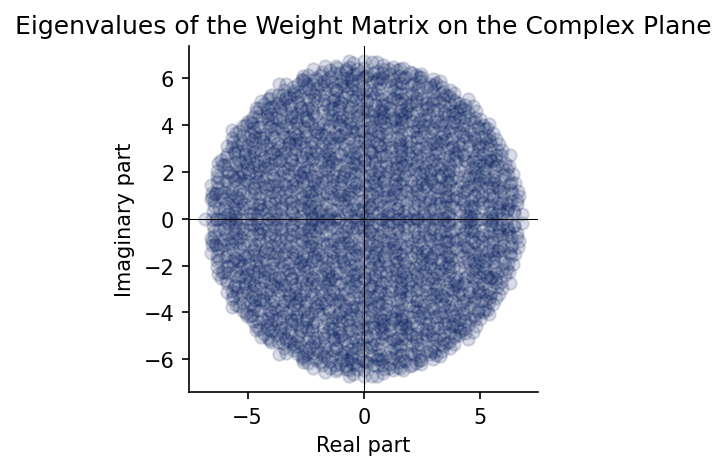

In [12]:
# Plot the eigenvalues on the complex plane
plt.figure(figsize=(3, 3), dpi=150)
plt.scatter(eig_w.real, eig_w.imag, alpha=0.15, edgecolor=None)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalues of the Weight Matrix on the Complex Plane')
sns.despine()
plt.show()

## Membrane Potential and synaptic current

In [13]:
def get_spike_and_reset(mem):
    mthr = mem - 1.0
    out = np.heaviside(mthr, 1)

    return out


In [14]:
mem_seq = [np.zeros(n_out)]
syn_seq = [np.zeros(n_out)]
out_seq = [np.zeros(n_out)]


for t in trange(int(duration // timestep)):
    inp_ff = spikes[t] @ weights_ff * alpha
    inp_rec = out_seq[-1] @ weights * (1 - alpha)

    # spike & reset
    new_out = get_spike_and_reset(mem_seq[-1])

    # synaptic & membrane dynamics
    new_syn = dcy_syn * syn_seq[-1] + inp_ff + inp_rec
    new_mem = (dcy_mem * mem_seq[-1] + scl_mem * syn_seq[-1]) * (1.0 - new_out)  # multiplicative reset
    # new_mem = -mem_seq[-1] * dcy_syn + inp_rec + inp_ff

    new_mem = np.clip(new_mem, a_max=1.01, a_min=-np.inf)

    mem_seq.append(new_mem)
    syn_seq.append(new_syn)
    out_seq.append(new_out)

100%|██████████| 1999/1999 [00:20<00:00, 98.06it/s] 


In [15]:
mem_seq = np.stack(mem_seq)
syn_seq = np.stack(syn_seq)
out_seq = np.stack(out_seq)

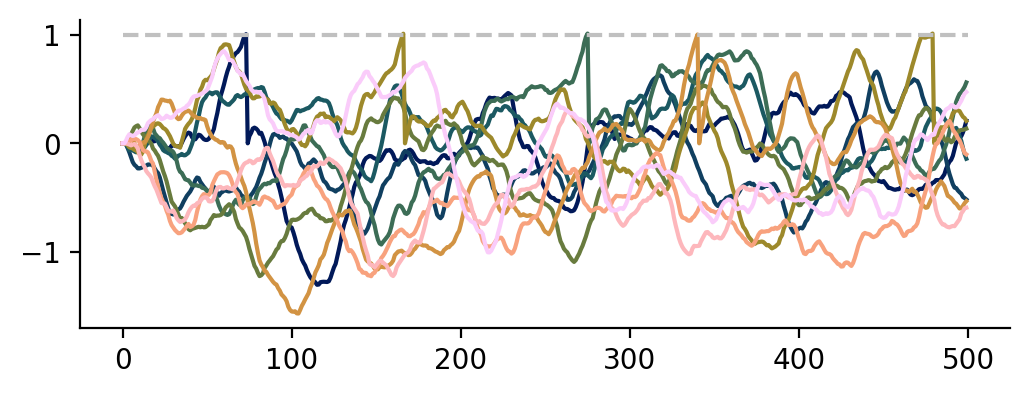

In [16]:
plt.figure(figsize=(6,2), dpi=200)
plt.plot(mem_seq[:500, :10])
plt.hlines(1,0,500, color="silver", ls="--")
sns.despine()

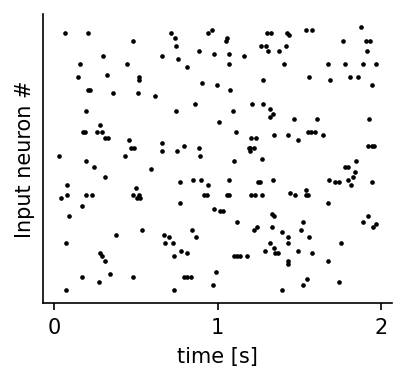

In [17]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_spikeraster(
    out_seq, timestep, ax, max_time=plot_maxtime, max_neurons=plot_maxneurons
)
ax.set_xticks(np.arange(0, plot_maxtime + 1, 1))
ax.set_yticks([])
ax.set_ylabel("Input neuron #")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [18]:
out_with_spikes = mem_seq + out_seq*2

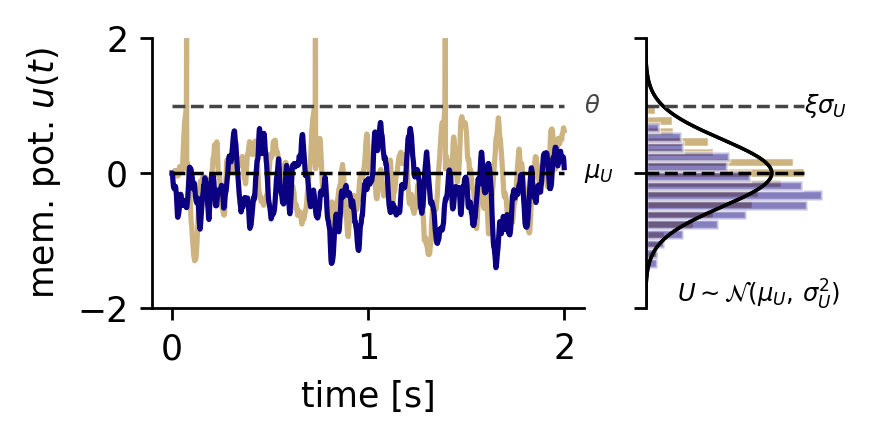

In [19]:
# specify plot parameters
figsize = (3.5, 1.4)
time_axis = np.arange(0, plot_maxtime, timestep)
minmax = (-2, 2)


fig, ax = plt.subplots(
    1, 2, figsize=figsize, dpi=250, gridspec_kw={"width_ratios": [0.7, 0.3]}
)


# plot membrane potential
ax[0].plot(
    time_axis, out_with_spikes[: len(time_axis), 0], color=color_membrane, lw=1.5
)
ax[0].plot(
    time_axis,
    out_with_spikes[: len(time_axis), 1],
    color="#0c0082",
    lw=1.5,
)
ax[0].hlines(theta, 0, plot_maxtime, color=color_theta, lw=1, ls="dashed", zorder=10)
ax[0].hlines(0, 0, plot_maxtime, color="black", lw=1, ls="dashed", zorder=10)

ax[0].set_ylim(minmax[0], minmax[1])
ax[0].set_xlabel("time [s]")
ax[0].set_ylabel(r"mem. pot. $u(t)$")
ax[0].set_xticks(np.arange(0, plot_maxtime + 1, 1))
ax[0].set_yticks([minmax[0], 0, minmax[1]])


# plot histogram of membrane potential with corresponding theoretical curve
plot_histogram_with_gaussian(
    mem_seq[:, 0],
    mu_U,
    sigma_U,
    ax[-1],
    color_membrane,
    "black",
    orientation="horizontal",
    minmax=minmax,
    bins=15,
)

plot_histogram_with_gaussian(
    mem_seq[:, 1],
    mu_U,
    sigma_U,
    ax[-1],
    "#0c0082",
    "black",
    orientation="horizontal",
    minmax=minmax,
    bins=15,
    alpha=0.5,
)


ax[1].hlines(theta, 0, 1, color=color_theta, lw=1, ls="dashed")
ax[1].hlines(0, 0, 1, color="black", lw=1, ls="dashed", zorder=10)
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_ylim(minmax[0], minmax[1])

ax[0].text(
    plot_maxtime + 0.1,
    theta,
    r"$\theta$",
    color=color_theta,
    fontsize=7,
    verticalalignment="center",
)
ax[0].text(
    plot_maxtime + 0.1,
    0,
    r"$\mu_U$",
    color="black",
    fontsize=7,
    verticalalignment="center",
)
ax[1].text(
    0.2,
    minmax[0] + 0.2,
    r"$U \sim \mathcal{N}(\mu_U,\,\sigma_U^{2})$",
    color="black",
    fontsize=7,
    verticalalignment="center",
)
ax[1].text(
    1.0, theta, r"$\xi \sigma_U$", color="black", fontsize=7, verticalalignment="center"
)

# Remove top and right spines
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.show()

In [20]:
# theory: power law
x = np.linspace(1, n_out, 100)

sym = (1 / x)**0.69
asym = (1 / x)**1.3

## check activity properties

In [21]:
activity = out_seq
activity = mem_seq

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'dpi'
  cset = contour_func(


Text(12.722222222222223, 0.5, 'Membrane potential Neuron 2')

<Figure size 400x400 with 0 Axes>

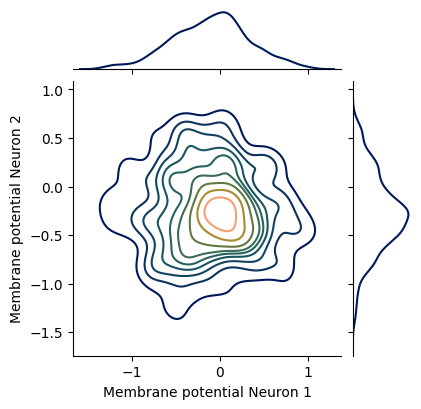

In [22]:
# Create a DataFrame for seaborn
data = {"Neuron 1": activity[:, 0], "Neuron 2": activity[:, 1]}
df = pd.DataFrame(data)

# Plot the density plot
plt.figure(figsize=(4, 4))
sns.jointplot(
    x=data["Neuron 1"],
    y=data["Neuron 2"],
    kind="kde",
    cmap=cm.batlow,
    height=4,
    ratio=4,
    dpi=250,
    palette=cm.batlow,
)

plt.xlabel("Membrane potential Neuron 1")
plt.ylabel("Membrane potential Neuron 2")

In [23]:
# Compute the correlation matrix of the membrane potentials over neurons
correlation_matrix = np.corrcoef(activity.T)

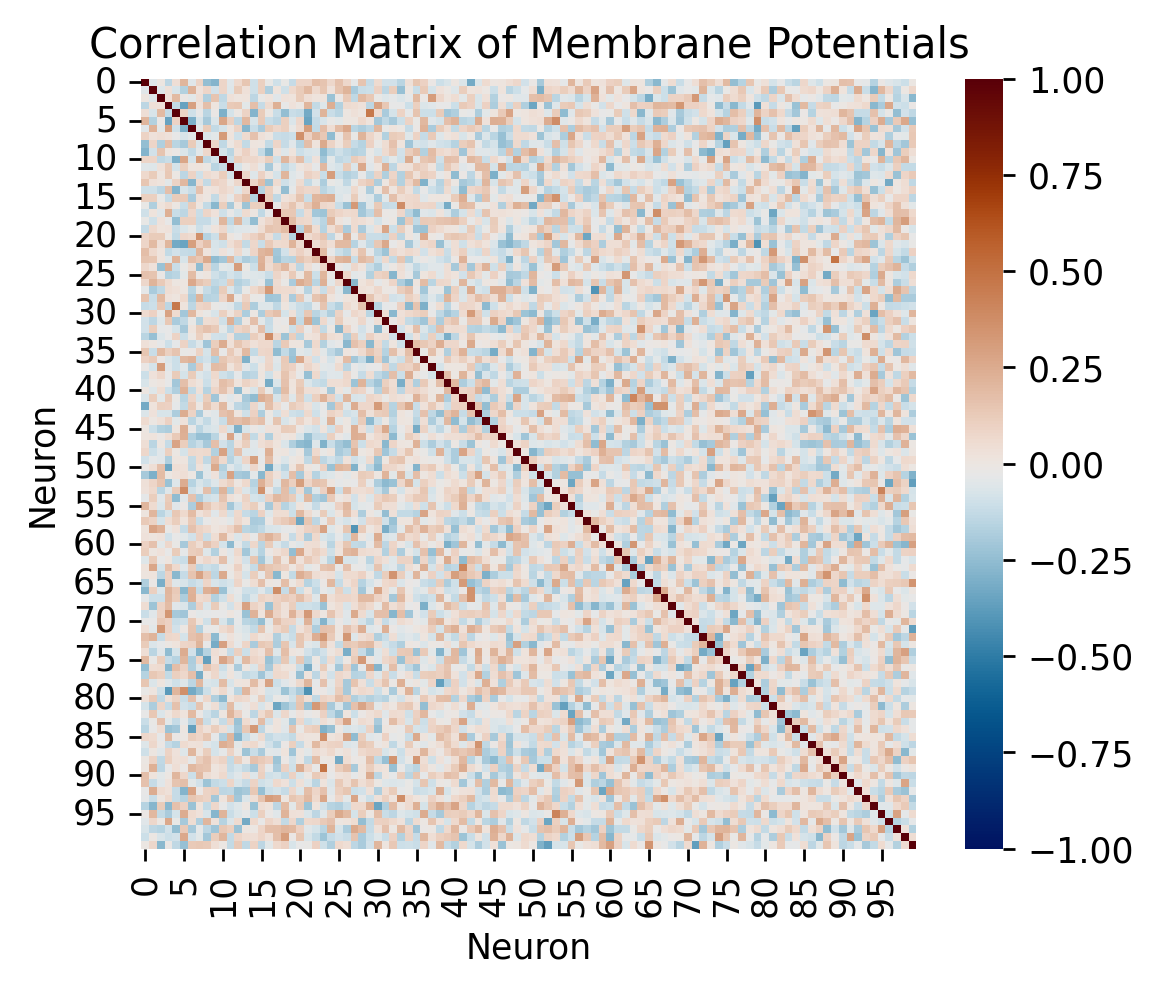

In [24]:
# Plot the correlation matrix
plt.figure(figsize=(5, 4), dpi=250)
sns.heatmap(
    correlation_matrix[:100, :100],
    cmap=cm.vik,
    center=0,
    vmin=-1,
    vmax=1,
)

# plt.xticks(np.linspace(0, n_out, 5),np.linspace(0, n_out, 5))
# plt.yticks(np.linspace(0, n_out, 5),np.linspace(0, n_out, 5))

plt.title("Correlation Matrix of Membrane Potentials")
plt.xlabel("Neuron")
plt.ylabel("Neuron")
plt.show()

In [25]:
# Compute the eigenvalues of the correlation matrix
eig_c = np.linalg.eigvals(correlation_matrix)

In [26]:
eig_C_norm = eig_c / np.max(eig_c)

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


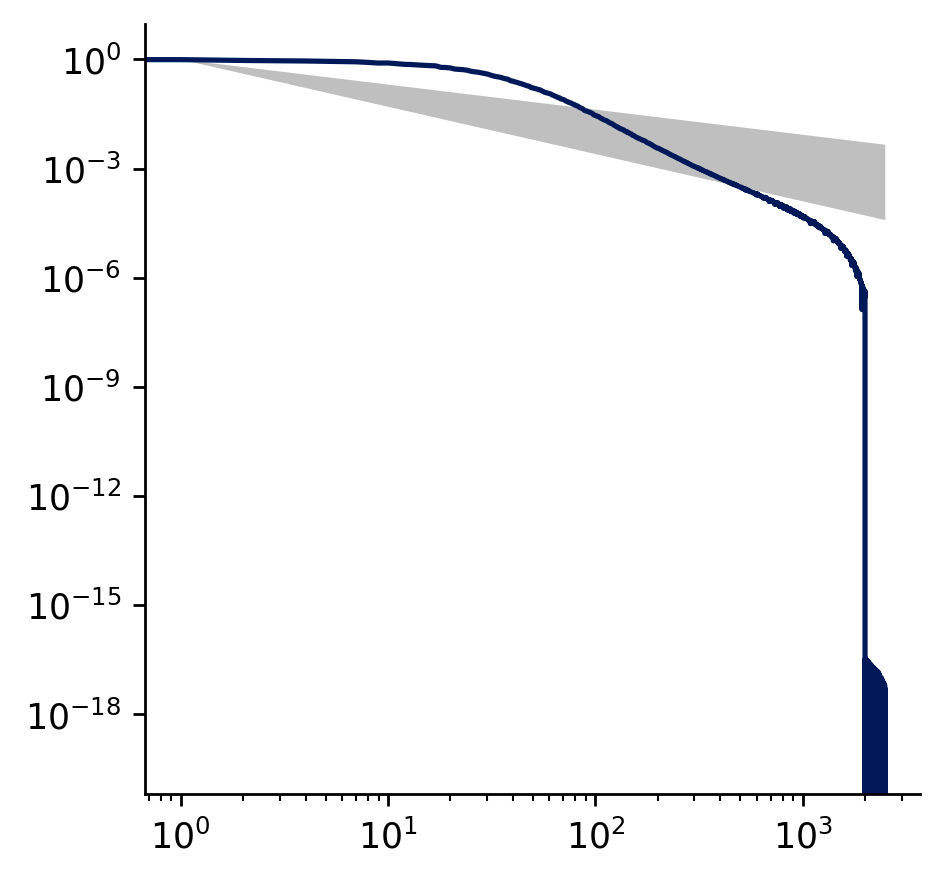

In [57]:
plt.figure(figsize=(4, 4), dpi=250)
plt.loglog(eig_C_norm)

plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

# plt.xlim(1, 1000)
# plt.ylim(0.000001, 1)

sns.despine()

In [28]:
# Apply PCA on the correlation matrix
pca = PCA()
pca.fit(correlation_matrix)

# Get the explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance /= 1/np.sqrt(n_out)

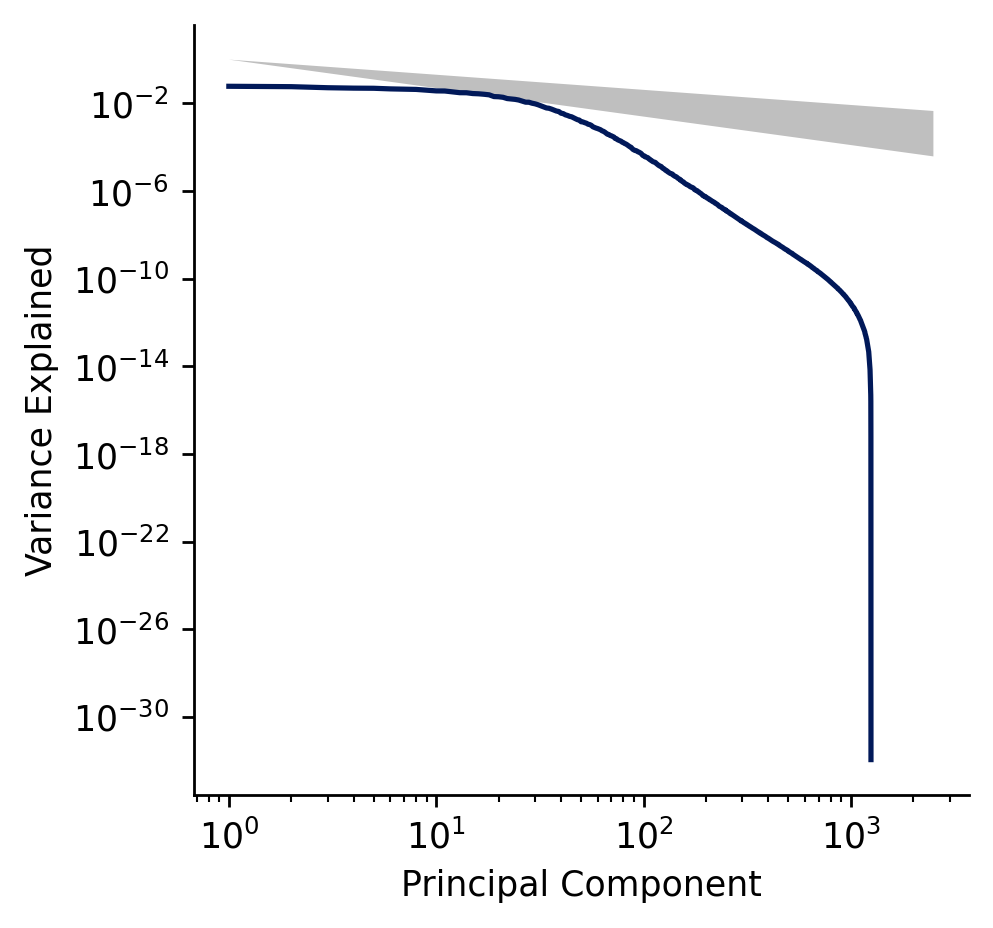

In [56]:
# Plot the explained variance
plt.figure(figsize=(4, 4), dpi=250)
plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

plt.loglog(
    np.arange(1, len(explained_variance) + 1), explained_variance,
)

# plt.xlim(1, 1000)
# plt.ylim(0.000001, 10)


plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
sns.despine()
plt.show()

### Covariance matrix and eigenvalues

In [43]:
# Split the states into two halves
half_point = N // 2
states_first_half = activity[:, :half_point]
states_second_half = activity[:, half_point:]

cov_between_halves = np.cov(states_first_half.T, states_second_half.T)[:half_point, half_point:]

In [50]:
cov_matrix = np.cov(activity.T)

cov_matrix = cov_between_halves
print(cov_matrix.shape)

(1250, 1250)


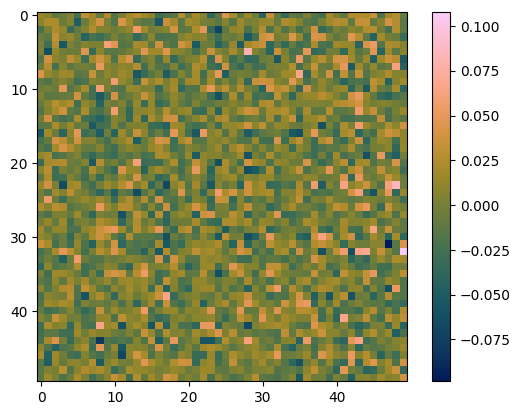

In [51]:
max_plot_steps = 50
im = plt.imshow(cov_matrix[:max_plot_steps,:max_plot_steps], cmap=cm.batlow)
plt.colorbar(im)

In [52]:
eig_cov = np.linalg.eigvals(cov_matrix)

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


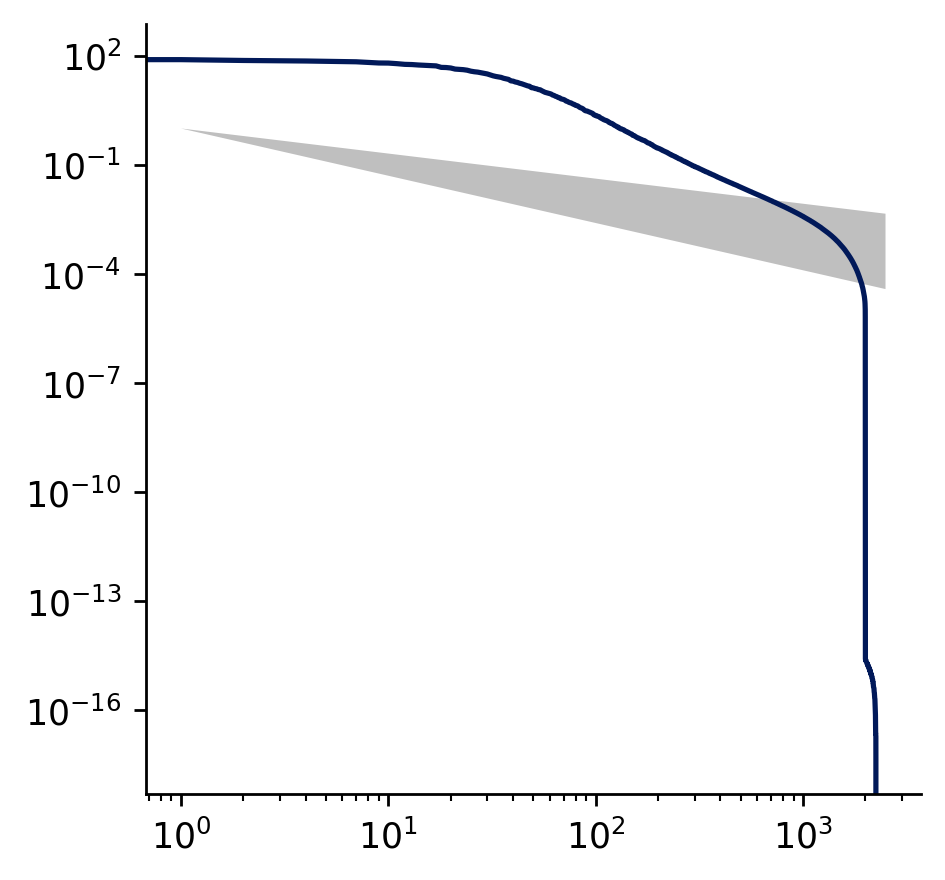

In [53]:
plt.figure(figsize=(4, 4), dpi=250)
plt.loglog(sorted(eig_c, reverse=True))

plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

# plt.xlim(1, 1000)
# plt.ylim(0.000001, 1)

sns.despine()

In [54]:
# Apply PCA on the correlation matrix
pca = PCA()
pca.fit(cov_matrix)

# Get the explained variance
explained_variance = pca.explained_variance_ratio_

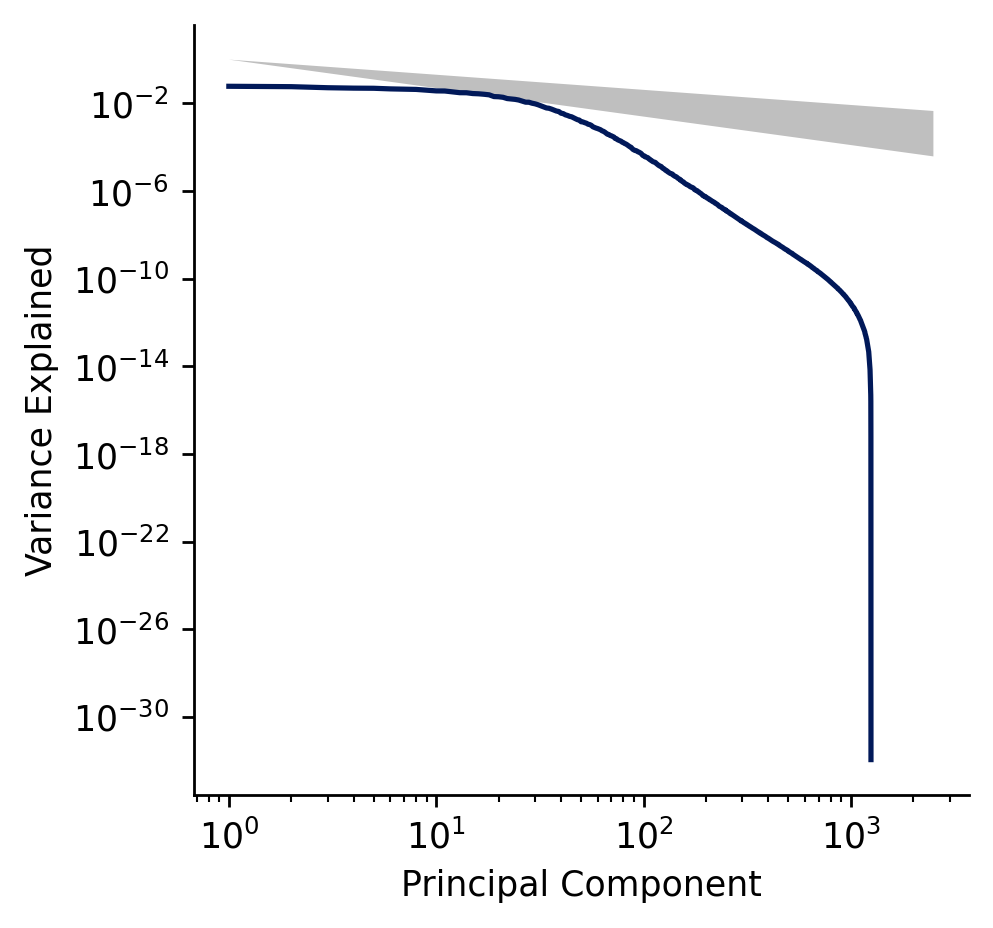

In [55]:
# Plot the explained variance
plt.figure(figsize=(4, 4), dpi=250)
plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

plt.loglog(
    np.arange(1, len(explained_variance) + 1), explained_variance,
)

# plt.xlim(1, 1000)
# plt.ylim(0.000001, 10)


plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
sns.despine()
plt.show()